In [1]:
## incomplete
## Load necessary packages
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

test_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

In [3]:
data_dir = "../Classic-Neural-Networks-Implementation/dogImages/"
train_data = datasets.ImageFolder(data_dir + "train/", transform = train_transform)
valid_data = datasets.ImageFolder(data_dir + "valid/", transform=train_transform)
test_data = datasets.ImageFolder(data_dir + "test/", transform = test_transform)

print("Number of Training Data: {}".format(len(train_data)))
print("Number of Testing Data: {}".format(len(test_data)))
print("Number of Validating Data: {}".format(len(valid_data)))


Number of Training Data: 6680
Number of Testing Data: 836
Number of Validating Data: 835


In [4]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


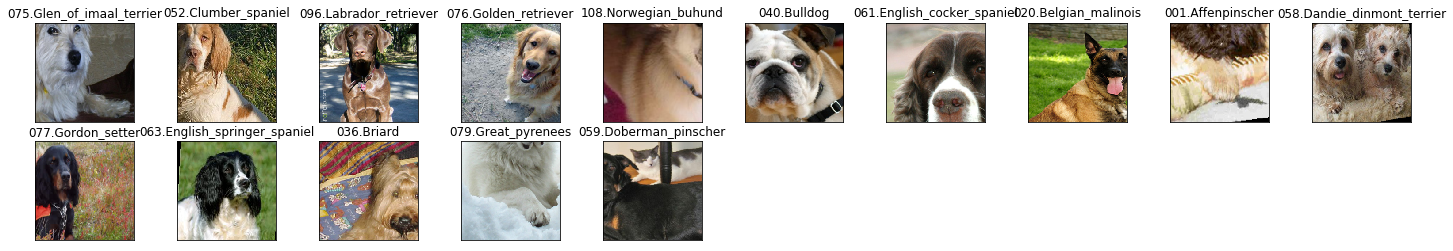

In [13]:
 # obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
train_on_gpu = True if torch.cuda.is_available() else False
if train_on_gpu:
    images = images.cuda()


# plot the images in the batch, along with predicted labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    img = images.cpu()[idx]
    img = img * 0.5 + 0.5
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    ax.set_title(test_data.classes[labels[idx].item()])


In [14]:
## Creating a residual block

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, use_1x1_conv=False,
                 stride=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)
                
        if use_1x1_conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                  stride=stride)
        else:
            self.conv3 = None
            
    def forward(self, x):
        y = self.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))

        
        if self.conv3:
            ## dimensions will be matched
            x = self.conv3(x)
            
        ## returns f(x) + x
        return self.relu(x+y)
        
        
        



In [15]:
output_size=133
class ResNet18(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64,
                              kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.get_renset_layer(64, 64, 2, first_block=True)
        self.layer2 = self.get_renset_layer(64, 128, 2)
        self.layer3 = self.get_renset_layer(128, 256, 2)
        self.layer4 = self.get_renset_layer(256, 512, 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, output_size)
        
        
    
    def get_renset_layer(self, in_channels, out_channels,
                         num_residual_blocks, first_block=False):
        
        layers = list()
        
        for i in range(num_residual_blocks):
            if i == 0 and not first_block:
                layers.append(ResidualBlock(in_channels, out_channels,
                                use_1x1_conv=True, stride=2))
            else:
                layers.append(ResidualBlock(in_channels, out_channels,
                                use_1x1_conv=False, stride=1))
            in_channels = out_channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        
        return x
        
        

In [16]:
resnet18 = ResNet18()
# resnet18

In [17]:
if train_on_gpu:
    resnet18 = resnet18.cuda()

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [ ]:
n_epochs = 40 ## Increase it to more
train_losses = []
valid_losses = []
valid_loss_min = np.inf

for e in range(n_epochs):
    train_loss = 0
    valid_loss = 0
    
    resnet18.train()
    
    for img, label in train_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        
        predicted_label = resnet18(img)
        loss = criterion(predicted_label, label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()
    
    resnet18.eval()
    
    for img, label in valid_loader:
        
        if train_on_gpu:
            img = img.cuda()
            label = label.cuda()
        predicted_label = resnet18(img)
        loss = criterion(predicted_label, label)
        
        valid_loss = valid_loss + loss.item()
    
    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader)
    valid_losses.append(valid_loss)
    
    print("Epoch: {} Train Loss: {} Valid Loss: {}".format(e+1, train_loss, valid_loss))
    
    if valid_loss < valid_loss_min:
        print("Validation Loss Decreased From {} to {}".format(valid_loss_min, valid_loss))
        valid_loss_min = valid_loss
        torch.save(resnet18.state_dict(), "resnet_.pth")
        print("Saving Best Model")
    
        
    


Epoch: 1 Train Loss: 5.128588456428792 Valid Loss: 4.886700378274018
Validation Loss Decreased From inf to 4.886700378274018
Saving Best Model
